# ¿Qué tan buenos somos para reconocer personas?

<img src="https://i.imgur.com/ECpBSfn.jpg" width="50%" />

<center>¿Jack Nicholson o Leonardo Dicaprio?</center>

<img src="http://1.bp.blogspot.com/_BQ05SdY_Qk0/SmoUY1TVaeI/AAAAAAAAAUE/NwiqQgpb_Dg/s400/Fabio+Posca+-+Bob+Pati%C3%B1o.jpg" width="50%" />

<div>

<img src="https://i.imgur.com/1IokFVT.png" width="50%" />

</div>

<center>¿Fisa o guerrero medieval?</center>

Como queda claro, a veces la cosa se puede complicar y no resulta tan sencillo :). 

Para poder hacer esto, tenemos un conjunto de datos de datos que consiste en algunas miles de imágenes clasificadas de ariel, fisa, gabi y mariano. En cada uno de estos casos tenemos la certeza (etiqueta) de quién es quién en cada uno. Este set de datos lo vamos a usar para entrenar el modelo y ver qué tan bien le está yendo a la hora de clasificar esas personas.

# Dependencias

Vamos a estar usando varias libs útiles, que se instalan con pip:

    pip install pillow scikit-learn pandas matplotlib tensorflow h5py sh jupyter

# Generar imágenes a partir de videos (opcional)

Para este caso en particular, extrajimos imágenes de un grupo de videos usando el programa `ffmpeg`. En linux, puede instalarse con:

    sudo apt install ffmpeg 
    
Y luego se pueden generar imágenes a partir de un video, usándolo de esta forma:

    ffmpeg -i PATH_VIDEO -r FPS/1 PATH_IMAGENES/PREFIJO_%03d.jpg
    
Esto requiere especificar el path al video, los FPS que queremos sacar (cuántas imágenes por segundo de video), y el path y formato de los nombres de los archivos a generar. Por ejemplo, si tenemos un video "ariel.mp4", y queremos generar imágenes a 5 fps en un directorio "fotos_ariel", podríamos correrlo así:

    ffmpeg -i ariel.mp4 -r 5/1 fotos_ariel/foto_%03d.jpg


# Imports y configs

In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

2022-04-25 20:02:54.294215: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64
2022-04-25 20:02:54.294240: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Datos
=====

Para que esto funcione, deben bajar y descomprimir los dos sets de imágenes desde [este link](https://drive.google.com/drive/folders/0B5cCDhynqkqDczZDd3JTSENFcDg?usp=sharing).

Cada set tiene 3 directorios de imágenes, uno por cada profe. Vamos a utilizar las imágenes con cortina de fondo como set de validación, y el resto como set de entrenamiento.

In [2]:
# lo vamos a estar usando seguido
PROFES = "ariel", "mariano", "fisa"
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAIN_DIR = Path('./imagenes/train')
VALIDATION_DIR = Path('./imagenes/validation')
SIZE = (64, 64)
COLOR = "rgb"
SEED = 42

Lo primero que vamos a hacer es crear datasets de imágenes para Keras, usando sus propias herramientas:

In [3]:
PARAMETROS_COMUNES_DATASET = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=PROFES,  # para usar el mismo orden en todos lados
    target_size=SIZE,  # para que corra más rápido, vamos a achicar las imágenes
    color_mode=COLOR,  # queremos trabajar con las imágenes a color
)

In [4]:
train_generator = ImageDataGenerator(rescale=1/255)
train = train_generator.flow_from_directory(TRAIN_DIR, **PARAMETROS_COMUNES_DATASET)

Found 2793 images belonging to 3 classes.


In [5]:
validation_generator = ImageDataGenerator(rescale=1./255)
validation = validation_generator.flow_from_directory(
    VALIDATION_DIR,
    batch_size=869,  # leer todas las imagenes de una sola vez
    **PARAMETROS_COMUNES_DATASET,
)

Found 869 images belonging to 3 classes.


In [6]:
train_generator_alterado = ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=False,
    vertical_flip=False,
)
train_alterado = train_generator_alterado.flow_from_directory(
    TRAIN_DIR,
    **PARAMETROS_COMUNES_DATASET,
)

Found 2793 images belonging to 3 classes.


Y con un poco de uso de Matplotlib, podemos mostrar ejemplos al azar de esas imágenes:

In [7]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(PROFES[np.argmax(labels[i])])
        plt.axis("off")

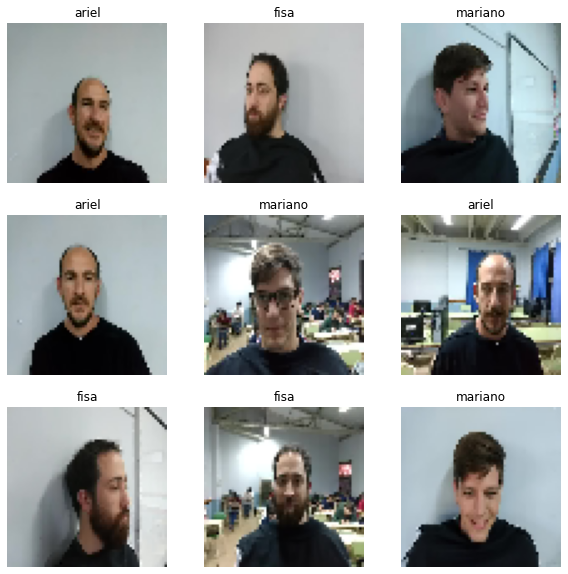

In [8]:
sample_images(train)

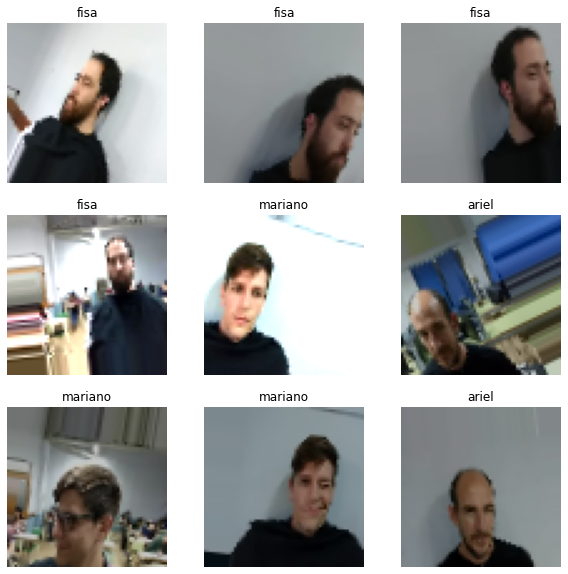

In [9]:
sample_images(train_alterado)

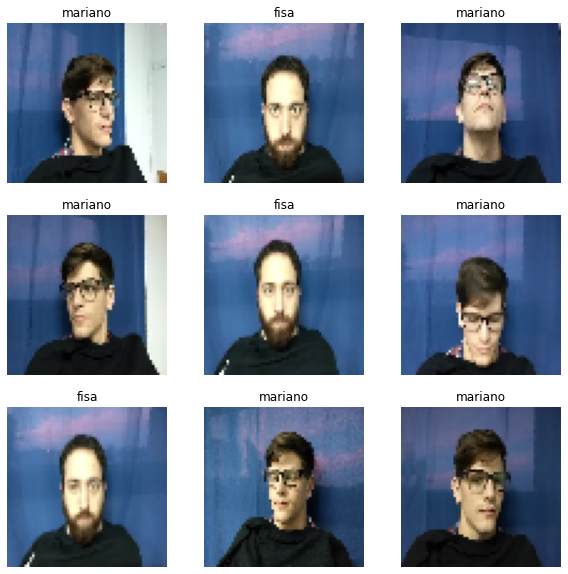

In [10]:
sample_images(validation)

Red neuronal
============

Y aquí es donde creamos y entrenamos el modelo. Vamos a usar redes convolucionales, porque se lleva naturalmente bien con el dataset que Keras nos sabe generar:

In [11]:
model = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    
    Convolution2D(input_shape=(64, 64, 3), filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x3, y salida de 61x61x8
    Dropout(0.2),
    
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    # kernels de 4x4x8, y salida de 58x58x8
    Dropout(0.2),
    
    MaxPooling2D(pool_size=(4, 4)),
    # salida de 14x14x8
    
    Flatten(),
    # salida de 1568
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),
    
    Dense(10, activation='tanh'),
    # salida de 10
    Dropout(0.2),

    Dense(len(PROFES), activation='softmax'),
    # salida de 3
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

2022-04-25 20:02:58.339977: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-8.0/lib64
2022-04-25 20:02:58.340001: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 20:02:58.340019: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupiter): /proc/driver/nvidia/version does not exist
2022-04-25 20:02:58.340206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 8)         392       
                                                                 
 dropout (Dropout)           (None, 61, 61, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 8)         1032      
                                                                 
 dropout_1 (Dropout)         (None, 58, 58, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                        

In [13]:
history = model.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=validation,
)

Epoch 1/5
88/88 [==============================] - 11s 120ms/step - loss: 0.6338 - accuracy: 0.7737 - val_loss: 0.6092 - val_accuracy: 0.7710
Epoch 2/5
88/88 [==============================] - 10s 116ms/step - loss: 0.1464 - accuracy: 0.9850 - val_loss: 0.3623 - val_accuracy: 0.8665
Epoch 3/5
88/88 [==============================] - 10s 112ms/step - loss: 0.0657 - accuracy: 0.9971 - val_loss: 0.2683 - val_accuracy: 0.9125
Epoch 4/5
88/88 [==============================] - 10s 109ms/step - loss: 0.0422 - accuracy: 0.9982 - val_loss: 0.5013 - val_accuracy: 0.7940
Epoch 5/5
88/88 [==============================] - 9s 104ms/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.5577 - val_accuracy: 0.8032


Graficamos accuracy de ambos conjuntos durante todo el proceso

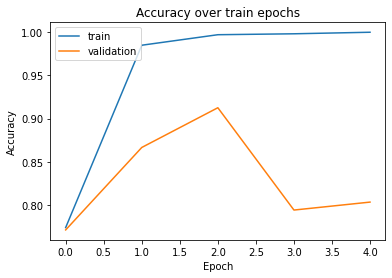

In [14]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Y analizamos un poco el error en ambos conjuntos, prediciendo y calculando métricas y matrices de confusión/

Found 2793 images belonging to 3 classes.
######################### train #########################


2022-04-25 20:03:53.037394: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 137281536 exceeds 10% of free system memory.


accuracy 1.0


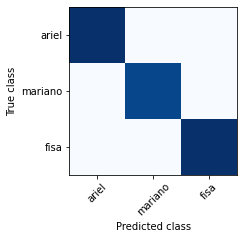

######################### validation #########################
accuracy 0.8032220943613348


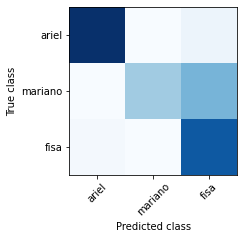

In [15]:
datasets = (
    (
        "train",
        train_generator.flow_from_directory(
            TRAIN_DIR,
            batch_size=train.samples,  # leer todas las imagenes de una sola vez
            **PARAMETROS_COMUNES_DATASET,
        ),
    ),
    (
        "validation",
        validation
    )
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = dataset.next()
    # super importante: usamos argmax para convertir cosas de este formato:
    # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
    # a este formato (donde tenemos el índice de la clase que tiene número más alto):
    # [1, 0, 0, 2]
    predictions = np.argmax(model.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('accuracy', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1, 2], PROFES, rotation=45)
    plt.yticks([0, 1, 2], PROFES)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

# Y ahora con imágenes nuevas, podemos usar nuestro predictor!

In [16]:
from IPython.display import Image, display


def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", PROFES[np.argmax(predictions)])
    print("Prediction detail:", predictions)

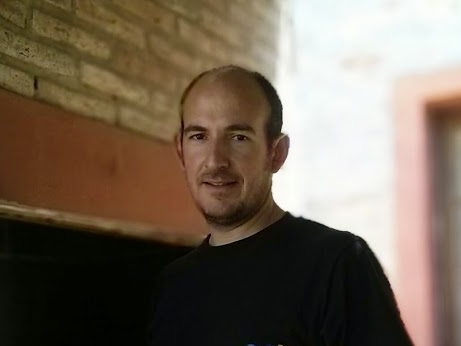

Prediction: ariel
Prediction detail: [[0.9938984  0.00216472 0.00393689]]


In [17]:
show_and_predict("./ariel_asado.jpg")

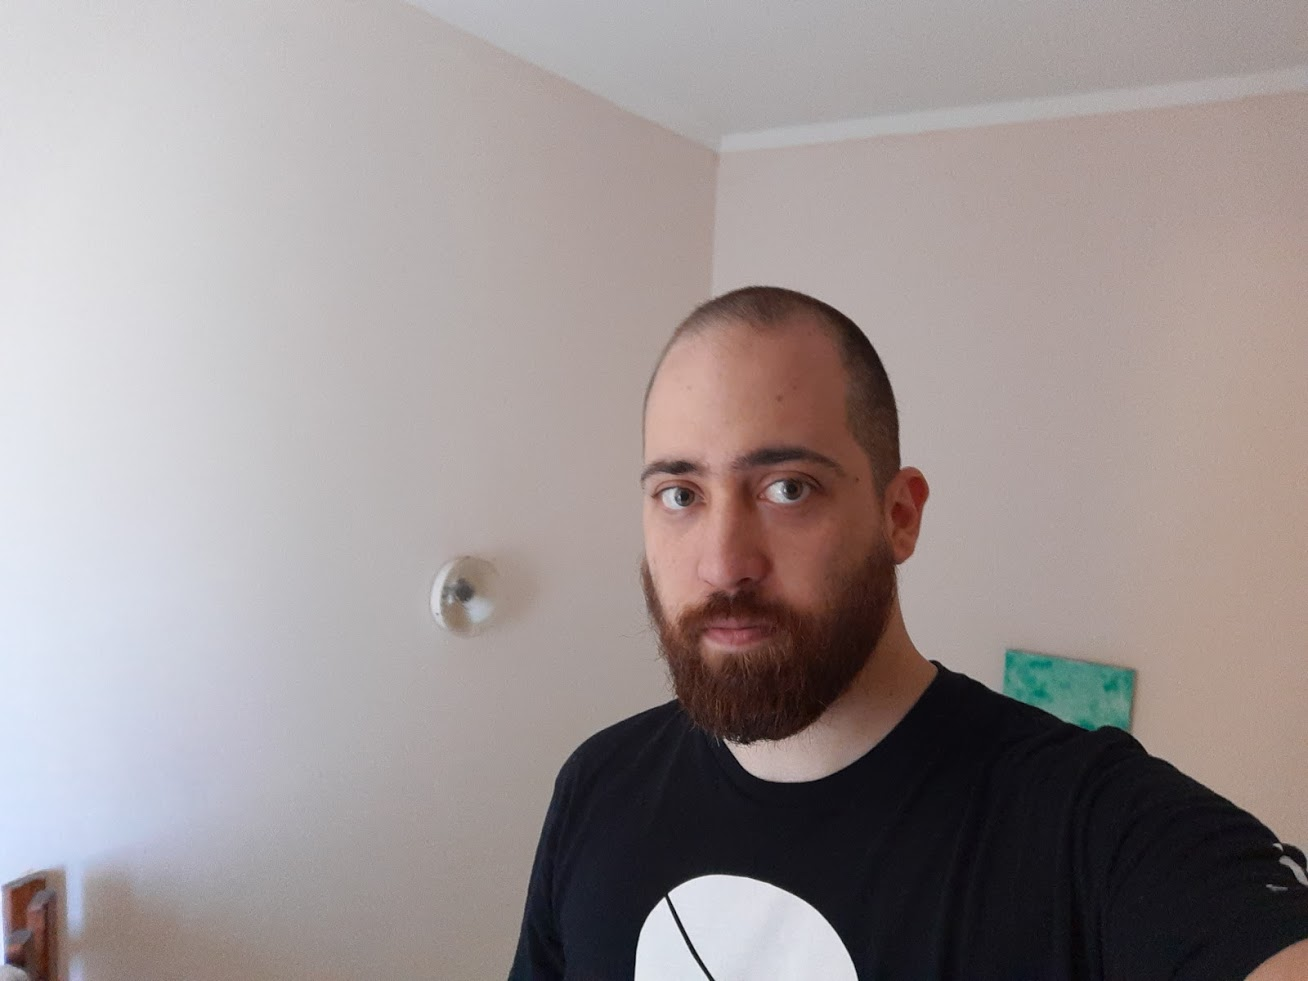

Prediction: fisa
Prediction detail: [[0.00233646 0.00379457 0.993869  ]]


In [18]:
show_and_predict("./fisa_pelado.jpg")